# TODO : 
- [ ] understand what's going on with covariance matrices
- [ ] understand how to better use patches 
- [ ] write preliminary results with cov = shot_noise 
- [ ] are the three samples independant ?
- 
- [x] update clmm usages
- [ ] remove astropy cosmo calls
- [x] test using clmm fitter
- [ ] adapt to use TxPipe outputs

In [1]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
from magnification_library import *
import pyccl
from scipy.optimize import curve_fit
from scipy import stats
import os

os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm.support.sampler import fitters

from importlib import reload  

In [2]:
pyccl.__version__

'2.2.0'

In [3]:
clmm.__version__

'0.9.4'

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
#define cosmology

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [6]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [7]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand, fig=None, ax=None, corr=False):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='o')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

## Open data

In [8]:
path_file = '../'

In [9]:
key = 'LBGp'

gal_cat =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null = dat[np.where(dat[:,0]==key)][0][1:]

In [10]:
selection_source = ( gal_cat['ra']>50) & ( gal_cat['ra']<73.1) & ( gal_cat['dec']<-27.) & ( gal_cat['dec']>-45.)
selection = selection_source * (gal_cat['mag_i_lsst']<mag_cut) * (gal_cat['redshift']>1.5)

/pbs/throng/lsst/software/desc/common/miniconda/py38_4.9.2/envs/desc/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/pbs/throng/lsst/software/desc/common/miniconda/py38_4.9.2/envs/desc/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [11]:
quant = np.load(path_file + "output_data/binned_correleation_fct_"+key+".npy", allow_pickle=True)

In [12]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

# **Compute model of magnification biais**

### - Concentration mass relation 

In [13]:
def get_halo_concentration(mass_lens, z_lens, cosmo_ccl, relation="Diemer15", mdef="matter", delta_so=200):
    mdef = pyccl.halos.massdef.MassDef(delta_so, mdef, c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_clmm.be_cosmo, M=mass_lens, a=cosmo_clmm._get_a_from_z(z=z_lens), mdef_other=mdef)
    return conc 

In [14]:
Mc_relation = "Diemer15"
mdef = ["matter", "mean"] #differet terminology for ccl and clmm
delta_so=200

print("Model parameters :\n mass_concentration relation =", Mc_relation,"\n",\
      "mass definition = SO mass within radius such that the density is ",delta_so, "times that of the ", mdef[0], "density of Universe at that redshift")


conc = np.zeros((5,5))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        conc[i,j] = get_halo_concentration(mass_cl[i,j], z_cl[i,j], cosmo_ccl, Mc_relation, mdef[0], delta_so )

Model parameters :
 mass_concentration relation = Diemer15 
 mass definition = SO mass within radius such that the density is  200 times that of the  matter density of Universe at that redshift


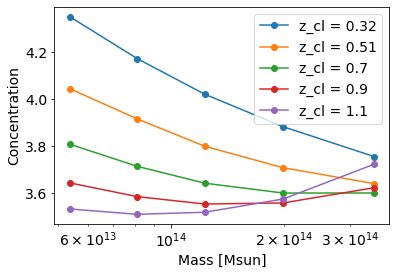

In [15]:
for i in range(len(z_cl)):
    plt.plot(mass_cl[0,:], conc[i,:], 'o-',  label = 'z_cl = '+str(np.round(z_cl[i,0],2)))
             
plt.xscale('log')

plt.legend()
plt.xlabel("Mass [Msun]")
plt.ylabel('Concentration');

### -  Modelisation of the source redshift distribution

Text(0, 0.5, 'pdf')

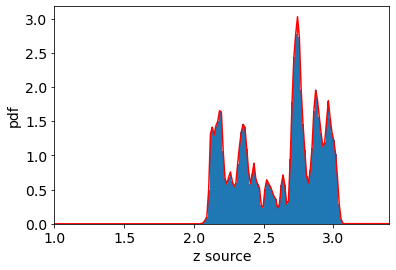

In [16]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [18]:
zint = np.linspace(0, 3.5, 1000)
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [19]:
print(zrand.mean())

2.606214214214214


### - Model for the magnification biais

In [20]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo_clmm, delta_so='200', massdef='mean', Mc_relation ='Diemer15'):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo_clmm.be_cosmo, Mc_relation, mdef[0], delta_so )
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(clmm.theory.compute_magnification(rproj[k], mdelta=mass_lens, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo_clmm, 
                                        delta_mdef=delta_so, 
                                        massdef = massdef,
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model
    

In [44]:
rp = np.logspace(-2, 1, 100)

In [22]:
#model with the full redshift distribution

model_full = np.zeros((rp.size, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model_full[:,i,j] = magnification_biais_model(rp, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)

/pbs/throng/lsst/users/mricci/desc/Magnification_project/cluster_magnification/magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


In [23]:
#model with source plane approximation at the mean true redshift of the sources

model_mz = np.zeros((rp.size, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model_mz[:,i,j] = magnification_biais_model(rp, mass_cl[i,j], z_cl[i,j], alpha_cut, np.mean(zrand), cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)

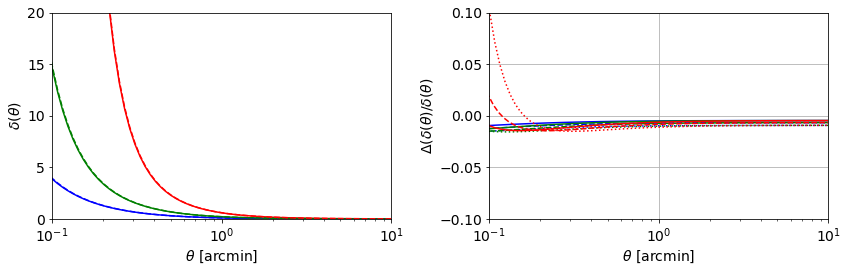

In [24]:
#b,g,r = lowest mass, intermediate mass, high mass

#items = [0,2,4]
items = [4]

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model_full[:,i,0],'b') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), model_full[:,i,2],'g') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), model_full[:,i,4],'r') for i in items]

#model with approximate mean redshift and source plane approximation
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model_mz[:,i,0],'b--') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), model_mz[:,i,2],'g--') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), model_mz[:,i,4],'r--') for i in items]

items = [2,3,4]

ls = ['solid','solid', 'solid', 'dashed', 'dotted']

[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), (model_full[:,i,0] - model_mz[:,i,0])/model_full[:,i,0],'b', ls =ls[i]) for i in items]
[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), (model_full[:,i,2] - model_mz[:,i,2])/model_full[:,i,2],'g', ls =ls[i]) for i in items]
[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), (model_full[:,i,4] - model_mz[:,i,4])/model_full[:,i,4],'r', ls =ls[i]) for i in items]


ax[0].set_xlim(0.1, 10)
ax[0].set_xscale('log')

ax[0].set_ylim(0,20)
ax[1].set_ylim(-0.1,0.1)
ax[1].grid()

ax[0].set_xlabel('$\\theta$ [arcmin]')
ax[0].set_ylabel('$\\delta$($\\theta$)')

ax[1].set_xlabel('$\\theta$ [arcmin]')
ax[1].set_ylabel('$\Delta (\\delta$($\\theta$)/$\\delta$($\\theta$)');

plt.tight_layout()

### _=>  Taking an imprecise redshift and using a source plane approximation biais the magnification biais profile (specifically in the inner part). Precise quantification of the biais depends on the cluster mass & z, and the source z distribution._

### - Plot data with predicted model (at mass_mean, z_mean)

In [25]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand, fig=None, ax=None, corr=False):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='.')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

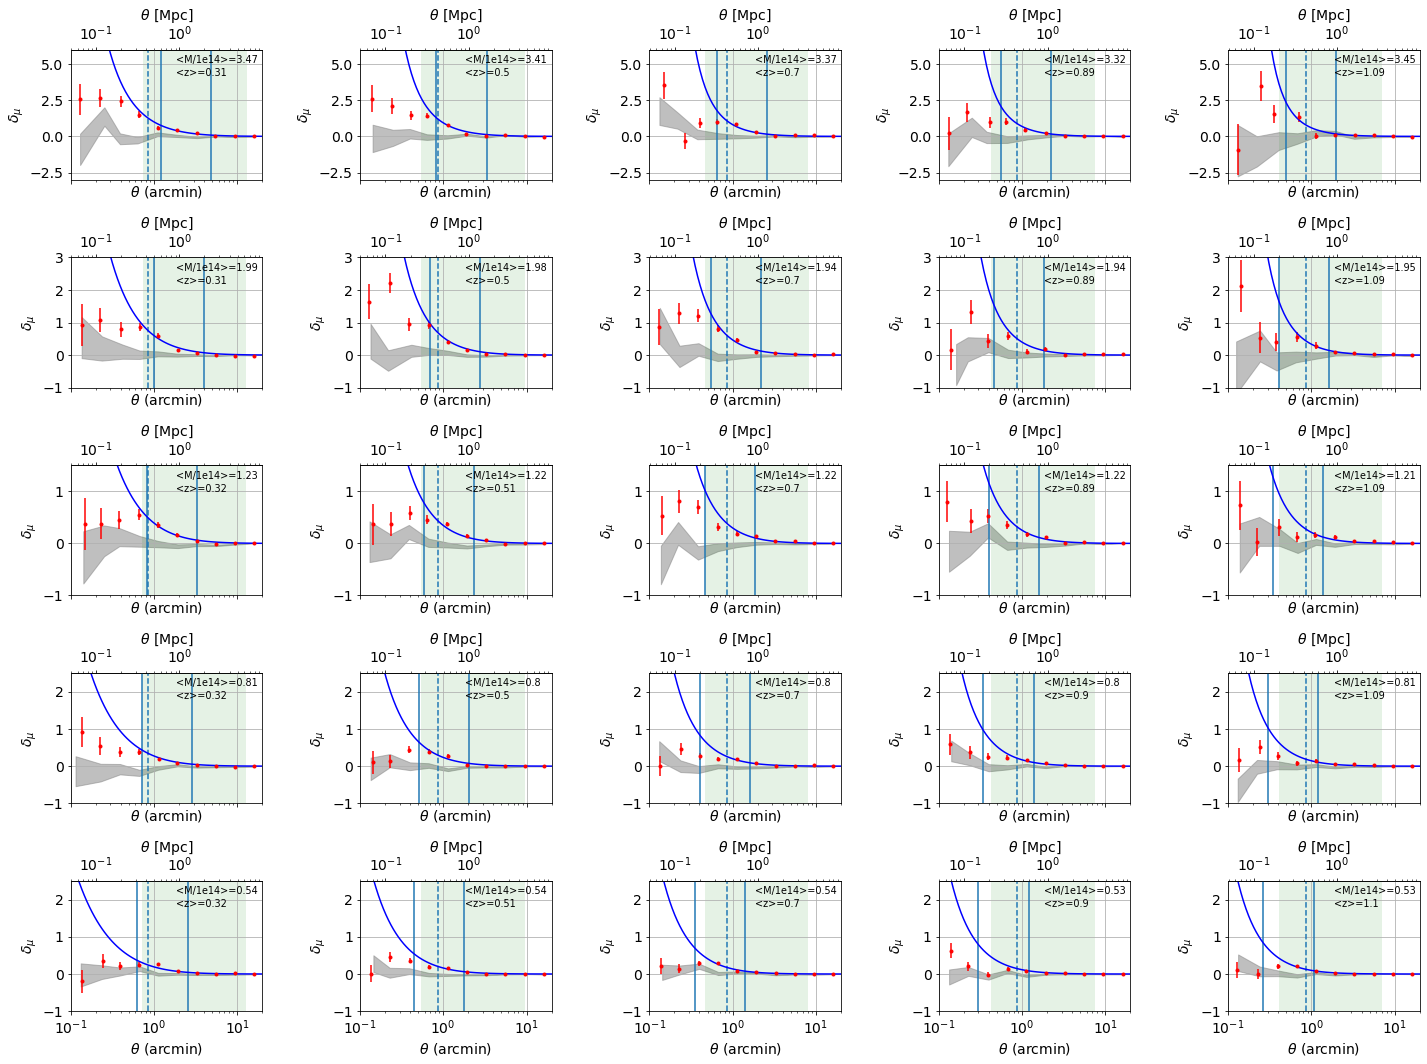

In [26]:

fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[5-1-k,h], corr=True)

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,j], cosmo=cosmo), model_full[:,i,j],'b')
        
        ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-1,2.5)
    axes[3,i].set_ylim(-1,2.5)
    axes[2,i].set_ylim(-1,1.5)
    axes[1,i].set_ylim(-1,3)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,20)

# **Fit the mean halo mass**
### 2 methods : 
 - chi2 minimization on a mass grid  : slow, allow for assymetrical errors
 - using scipy.optimize.curve_fit    : fast, only symetric errors
#### We checked that both methods give similar results.

In [27]:
#keyword because the method is slow
method_chi2_min = False

In [28]:
#radial range to ensure ~ 0.2 to 3.5 Mpc
step_low = np.array([4,3,3,3,3]) +1
step_high = 10 - np.array([-1,-1,-2,-2,-2]) 

mass_eval = np.zeros((z_cl.shape))
mass_min = np.zeros((z_cl.shape))
mass_max = np.zeros((z_cl.shape))

### - **chi2 minimization**

In [29]:
if method_chi2_min:
    
    mass_guess = np.logspace(12,16,500, base=10)

    fmodel_guess = np.zeros((len(z_cl), len(mass_guess)), dtype=object)
    model_guess = np.zeros((rp.size, len(mass_guess), len(z_cl)))

    for i in range(len(z_cl)):
        print(i)
        for l in range(len(mass_guess)):
            model_guess[:, l, i] = magnification_biais_model(rp, mass_guess[l], z_cl[i,0], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)
            x = Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo)
            fmodel_guess[i, l] = itp.interp1d(x, model_guess[:, l, i])

In [30]:
if method_chi2_min:
    
    chi2_val = np.zeros((z_cl.shape[0], z_cl.shape[1], len(mass_guess)))

    i,j = 0,0

    for i in range(len(z_cl)):
        for j in range(len(mass_cl)):
            for l in range(len(mass_guess)):
                chi2_val[i,j,l] = sum_chi2(quant[i,j][1], quant[i,j][2], fmodel_guess[i,l](quant[i,j][0]), step_low[i], step_high[i], cov=True)

In [31]:
if method_chi2_min:
    
    ind = np.zeros((z_cl.shape))

    for i in range(z_cl.shape[0]):
        for j in range(z_cl.shape[1]):
        #eval_mass, eval_mass_min, eval_mass_max 
            mass_eval[i,j], mass_min[i,j], mass_max[i,j], ind[i,j] = mass_minimization(chi2_val[i,j,:], mass_guess, s=1.)
            #print("True mass", mass[i,j]/1e13)
            #print( "evaluated mass =, %1.2e" % results[i,j][0])
            #[print ("sigma =", np.array([1.,2.,3.])[i], ", min mass =", "%1.2e" % eval_mass_min[i], ", max mass =", "%1.2e" % eval_mass_max[i]) for i in range(3)];
            
mass_eval_chi2 = mass_eval 
err_chi2 = (mass_max-mass_min)/2.

In [32]:
#plot to verify the chi2 minimization

if method_chi2_min:
    
    i,j=1,2

    plt.plot(mass_guess, chi2_val[i,j,:],'b.-')

    plt.xscale('log')
    plt.yscale('log')

    plt.axvline(mass_cl[i,j], color='red')
    plt.axhline(np.min(chi2_val[i,j,:]),  color='black', alpha=1,linestyle="dotted")
    plt.axvline(mass_eval[i,j],  color='black', alpha=1,linestyle="dotted")

    [plt.axhline(np.min(chi2_val[i,j,:]) + u ) for u in stats.chi2.ppf(stats.chi2.cdf( np.array([1.,2.,3.])**2,1), 1)];

    #[plt.axvline(mass_min[i,j][i], alpha=0.5) for i in range(3)];
    #[plt.axvline(mass_max[i,j][i], alpha=0.5) for i in range(3)];

    plt.ylim(0,100)

    plt.ylabel("chi2")
    plt.xlabel("mass eval [Msun]")

### - **curve_fit**

In [33]:
def predict_function(radius_arcmin, logM, z_cl):
    mass_guess = 10**logM
    radius_Mpc = arcmin_to_Mpc(radius_arcmin, z=z_cl, cosmo=cosmo)
    return magnification_biais_model(radius_Mpc, mass_guess, z_cl, alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)

In [34]:
def fit_mass(predict_function, data_for_fit, z, step_low, step_high):
    popt, pcov = fitters['curve_fit'](lambda radius_arcmin, logM: predict_function(radius_arcmin, logM, z),
        data_for_fit[0][step_low:step_high], 
        data_for_fit[1][step_low:step_high], 
        np.sqrt(np.diag(data_for_fit[2]))[step_low:step_high], bounds=[10.,17.], absolute_sigma='True', p0=(13.))
    logm, logm_err = popt[0], np.sqrt(pcov[0][0])
    return {'logm':logm, 'logm_err':logm_err,
            'm': 10**logm, 'm_err': (10**logm)*logm_err*np.log(10)}

In [35]:
fit_mass_magnification = np.zeros(z_cl.shape, dtype=object)

for i in range(5):
    for j in range(5):
        fit_mass_magnification[i,j] = fit_mass(predict_function, quant[i,j], z_cl[i,j], step_low[i], step_high[i])
        if not method_chi2_min:
            mass_eval[i,j] = fit_mass_magnification[i,j]['m']
            mass_min[i,j] = fit_mass_magnification[i,j]['m'] - fit_mass_magnification[i,j]['m_err']
            mass_max[i,j] = fit_mass_magnification[i,j]['m'] + fit_mass_magnification[i,j]['m_err']

/pbs/throng/lsst/users/mricci/desc/Magnification_project/cluster_magnification/magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


### - **comparison 2 mass estimation**

In [36]:
# comparison of the two mass estimation 

if method_chi2_min:
    for i in range(5):
        for j in range(5):
            print(f"Mass = {mass_cl[i,j]/1e14:.3}", f", z = {z_cl[i,j]:.2}")
            print(f"Mass curv = {fit_mass_magnification[i,j]['m']/1e14:.3}", f"\pm {fit_mass_magnification[i,j]['m_err']/1e14:.3}")
            print(f"Mass chi2 = {mass_eval_chi2[i,j]/1e14:.3}", f"\pm {err_chi2[i,j]/1e14:.3}\n")
else : 
    print('Chi2 method not performed')

Chi2 method not performed


### - mass estimates checking

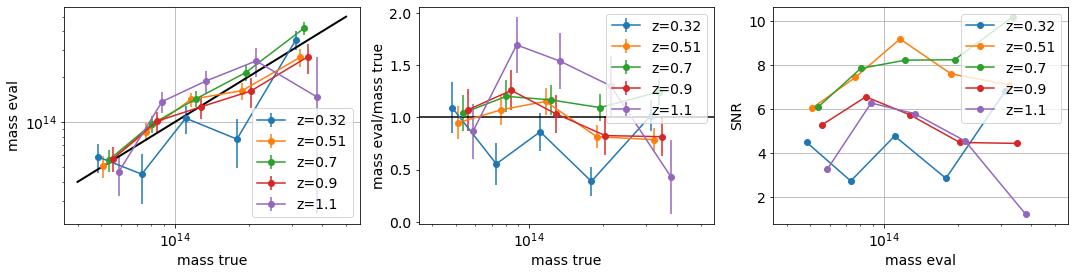

In [37]:

fig, ax = plt.subplots(1, 3, figsize=(18,4), sharex=True)

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend()
ax[0].set_xlabel("mass true")
ax[0].set_ylabel("mass eval")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
ax[1].legend()
ax[1].set_xlabel("mass true")
ax[1].set_ylabel("mass eval/mass true")


ax[2].plot(mass_cl[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].plot(mass_cl[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].plot(mass_cl[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].plot(mass_cl[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].plot(mass_cl[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].set_xscale('log')
ax[2].legend()
ax[2].set_ylabel("SNR")
ax[2].set_xlabel("mass eval")
ax[2].grid()

mean =  -0.013981471321180071 std =  1.5548215694434186


Text(0.5, 0, '(mass eval-mass true)/err.')

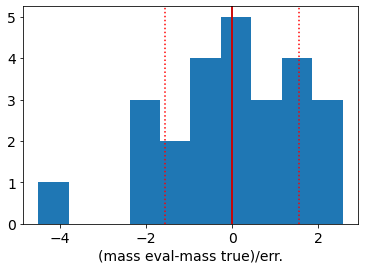

In [38]:
err = (mass_max-mass_min)/2.
relative_diff = ((mass_eval - mass_cl)/err).flatten()

print( "mean = ", np.nanmean(relative_diff), "std = ", np.nanstd(relative_diff))

plt.hist(relative_diff,bins=10)
plt.axvline(0, color='black')

plt.axvline(np.nanmean(relative_diff), color='red')
plt.axvline(np.nanmean(relative_diff) + np.nanstd(relative_diff), color='red', linestyle='dotted')
plt.axvline(np.nanmean(relative_diff) - np.nanstd(relative_diff), color='red', linestyle='dotted')

plt.xlabel("(mass eval-mass true)/err.")

### - plot data, expected model + fitted model

In [54]:
model_for_fitted_mass = np.zeros(z_cl.shape,dtype=object)

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
        if method_chi2_min:
            model_for_fitted_mass[i,j] = model_guess[:,int(ind[i,j]), i]
        else :    
            model_for_fitted_mass[i,j] = magnification_biais_model(rp, mass_eval[i,j], z_cl[i,j], alpha_cut, zrand, cosmo_clmm, delta_so, massdef=mdef[1], Mc_relation=Mc_relation)

/pbs/throng/lsst/users/mricci/desc/Magnification_project/cluster_magnification/magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


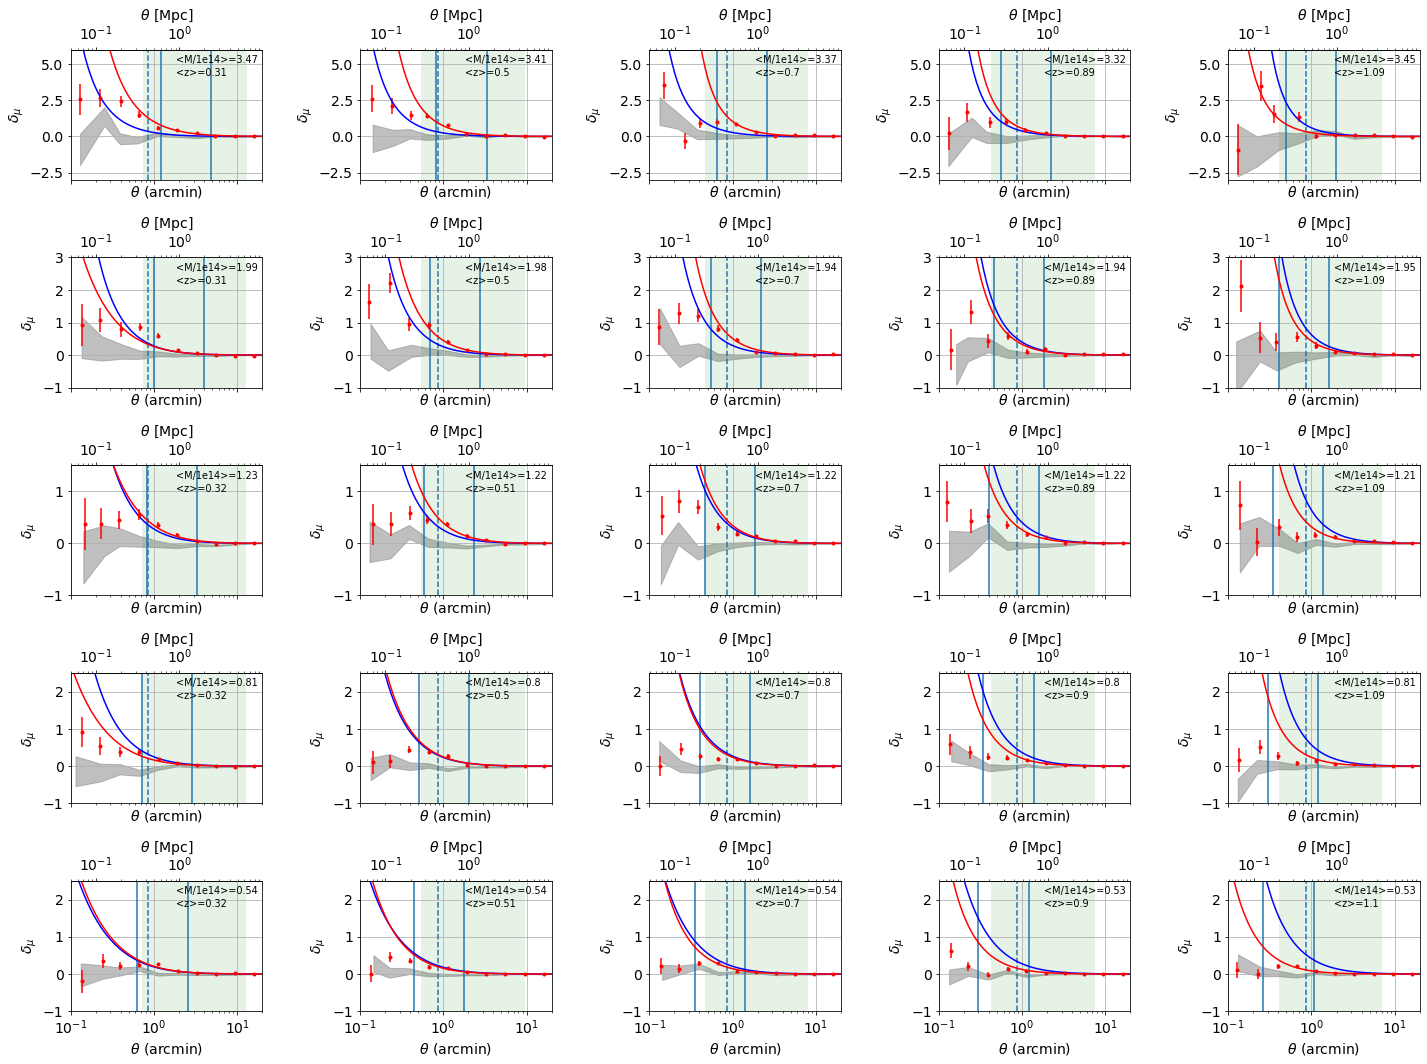

In [53]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[5-1-k,h], corr=True)

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,j], cosmo=cosmo), model_full[:,j,i],'b')
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,j], cosmo=cosmo), model_for_fitted_mass[i,j],'r')
             
        #ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model_guess[:,int(ind[i,j]), i],'r')
        
        ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-1,2.5)
    axes[3,i].set_ylim(-1,2.5)
    axes[2,i].set_ylim(-1,1.5)
    axes[1,i].set_ylim(-1,3)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,20)

### - print and save results

In [55]:
print("Source type : ", key,"\n")

i=4

for j in range(5):
    print(f'Mean halo redshift = {z_cl[i,j]:.2}')
    print(f'Mean true halo mass = {mass_cl[i,j]:.2e} Msun')
    print(f'Best fit mass = {mass_eval[i,j]:.2e} +/- {err[i,j]:.2e} Msun\n')
    
print("output_data/fitted_mass_"+key+"_"+mdef[0]+str(delta_so)+"_cM_"+Mc_relation)    
#np.save("output_data/fitted_mass_"+key+"_"+mdef+str(delta_so)+"_cM_"+Mc_relation,[mass_eval, mass_min, mass_max])

Source type :  LBGp 

Mean halo redshift = 1.1
Mean true halo mass = 5.35e+13 Msun
Best fit mass = 4.63e+13 +/- 1.42e+13 Msun

Mean halo redshift = 1.1
Mean true halo mass = 8.06e+13 Msun
Best fit mass = 1.37e+14 +/- 2.18e+13 Msun

Mean halo redshift = 1.1
Mean true halo mass = 1.21e+14 Msun
Best fit mass = 1.87e+14 +/- 3.23e+13 Msun

Mean halo redshift = 1.1
Mean true halo mass = 1.95e+14 Msun
Best fit mass = 2.54e+14 +/- 5.61e+13 Msun

Mean halo redshift = 1.1
Mean true halo mass = 3.45e+14 Msun
Best fit mass = 1.47e+14 +/- 1.22e+14 Msun

output_data/fitted_mass_LBGp_matter200_cM_Diemer15
